In [1]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import axion_motion
import model
import transport_equation
import reheating
from common import cosmology, constants, util
from common.rh_neutrino import calc_Gamma_a_SU2
from transport_eq import model as rad_dom_model
from transport_eq import axion_motion as rad_dom_axion_motion

In [69]:
T_osc = 4e13
T_RH = 1e12
m_a = 2 * cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_osc))
print("m_a(T_osc) = %e" % m_a)
m_a = 1e10
# T_dec = 1e11
decay_rate = 0 # cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_dec))
Gamma_phi = cosmology.calc_inflaton_decay_rate_from_reheating_temperature(T_RH)
print(f"Gamma_phi(T_RH) = {Gamma_phi:.2e}")
H_inf = 1e12 

m_a(T_osc) = 4.496386e+09
Gamma_phi(T_RH) = 2.50e+06


In [3]:
m = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
m2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))

In [16]:
%time ress = model.solve_to_end(m, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True, t_end=5e-6)

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /


done: SimulationState(initial=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), initial_reheating=(141.03361138137996, 141.03361138137996), t_start=1e-12, t_end=5e-06)
CPU times: user 7min 26s, sys: 10.7 s, total: 7min 36s
Wall time: 7min 37s


In [36]:
%time ress2 = rad_dom_model.solve_to_end(m2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, T_end=4e11, collect=True)

CPU times: user 1min 41s, sys: 112 ms, total: 1min 41s
Wall time: 1min 41s


In [65]:
def plot(ress, ress2, filename=None):
    plt.figure(figsize=(15,5))

    for i, (res, res2) in enumerate(zip(ress, ress2)):
        plt.subplot(1,2,1)
        plt.loglog(res.t, -transport_equation.calc_B_minus_L(res.red_chem_pots), color="black", label="reheating" if i == 0 else None)
        t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(res2.T)))
        plt.loglog(t, -transport_equation.calc_B_minus_L(res2.red_chem_pots), color="red", label="radiation domination" if i == 0 else None)

        plt.subplot(1,2,2)
        T = res.T_fn(res.t)
        plt.loglog(T, -transport_equation.calc_B_minus_L(res.red_chem_pots), color="black", label="reheating" if i == 0 else None)
        plt.loglog(res2.T, -transport_equation.calc_B_minus_L(res2.red_chem_pots), color="red", label="radiation domination" if i == 0 else None)

    plt.subplot(1,2,1)
    plt.ylim(1e-15, 1e-7)
    plt.xlabel("t * GeV", fontsize=15)
    plt.ylabel(r"$\mu_{B - L} / T$", fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.ylim(1e-15, 1e-7)
    plt.xlabel("T / GeV", fontsize=15)
    plt.gca().invert_xaxis()
    plt.yticks([])
    plt.legend()
    
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(util.make_plot_path(filename))
    
    plt.show()

In [22]:
roots = lambda theta: np.sum(np.sign(theta[:-1]) != np.sign(theta[1:]))
sum([roots(res.axion[0]) for res in ress])

31830

<ipython-input-65-dbcb5bbaa7d6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-65-dbcb5bbaa7d6>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)
<ipython-input-65-dbcb5bbaa7d6>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

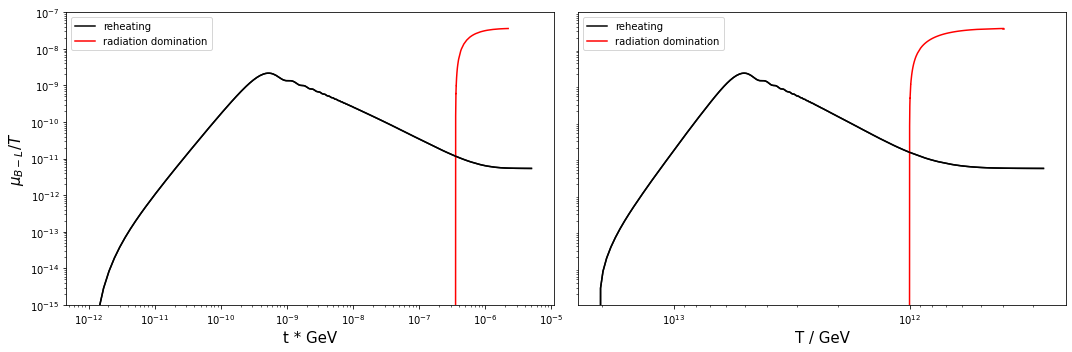

In [66]:
plot(ress, ress2, "rh_vs_raddom_bad_case.pdf")

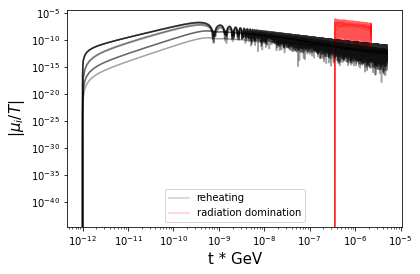

In [88]:
for i, (res, res2) in enumerate(zip(ress, ress2)):
    for n in range(transport_equation.N):
        plt.plot(res.t, np.abs(res.red_chem_pots[n]), color="black", label="reheating" if i == 0 and n == 0 else None, alpha=0.2)
        t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(res2.T)))
        plt.plot(t, np.abs(res2.red_chem_pots[n]), color="red", label="radiation domination" if i == 0 and n == 0 else None, alpha=0.2)

#plt.ylim(1e-15, 1e-7)
plt.xlabel("t * GeV", fontsize=15)
plt.ylabel(r"$|\mu_i / T|$", fontsize=15)
plt.legend()
plt.xscale("log")
plt.yscale("log")

In [89]:
transport_equation.charge_vector_B_minus_L

array([-1.        , -1.        , -1.        ,  0.33333333,  0.33333333,
        0.33333333,  0.33333333,  0.33333333,  0.        ])

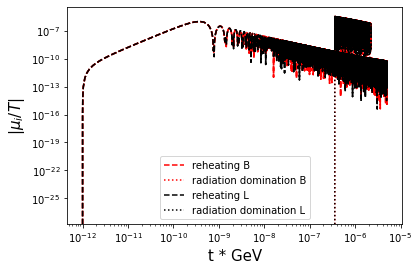

In [104]:
B_cv = np.array([0        , 0       , 0        ,  0.33333333,  0.33333333,
        0.33333333,  0.33333333,  0.33333333,  0.        ])
L_cv = np.array([1        , 1.        , 1.        ,  0,  0.0,
        0.0,  0.0,  0.0,  0.        ])

for i, (res, res2) in enumerate(zip(ress, ress2)):
    for name, charge_vec, color in zip(["B", "L"], [B_cv, L_cv], ["red", "black"]):
        f = lambda red_chem_pots: (charge_vec * transport_equation.dofs) @ red_chem_pots
        C = np.abs(f(res.red_chem_pots))
        plt.plot(res.t, C, color=color, ls="--", label="reheating " + name if i == 0 else None, alpha=1)
        t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(res2.T)))
        plt.plot(t, np.abs(f(res2.red_chem_pots)), color=color, ls=":", label="radiation domination " + name if i == 0 else None, alpha=1)

#plt.ylim(1e-15, 1e-7)
plt.xlabel("t * GeV", fontsize=15)
plt.ylabel(r"$|\mu_i / T|$", fontsize=15)
plt.legend()
plt.xscale("log")
plt.yscale("log")

In [95]:
res.red_chem_pots.shape

(9, 121401)

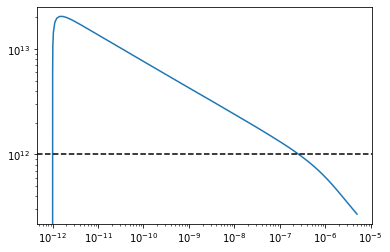

In [74]:
plt.loglog(ress[0].t, ress[0].T_fn(ress[0].t), label="radiation temperature")
plt.axhline(T_RH, color="black", ls="--", label="reheating temperature")

In [76]:
m_a = 1e6
Gamma_phi = cosmology.calc_inflaton_decay_rate_from_reheating_temperature(T_RH)

In [77]:
m = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
m2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))

In [80]:
%time ress_good = model.solve_to_end(m, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True, t_end=5e-5)
%time ress2_good = rad_dom_model.solve_to_end(m2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, T_end=4e11, collect=True)

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /


done: SimulationState(initial=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), initial_reheating=(141.03361138137996, 141.03361138137996), t_start=1e-12, t_end=5e-05)
CPU times: user 1.15 s, sys: 3.95 ms, total: 1.15 s
Wall time: 1.16 s
CPU times: user 1.36 s, sys: 3.94 ms, total: 1.37 s
Wall time: 1.38 s


<ipython-input-65-dbcb5bbaa7d6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-65-dbcb5bbaa7d6>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)
<ipython-input-65-dbcb5bbaa7d6>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and ret

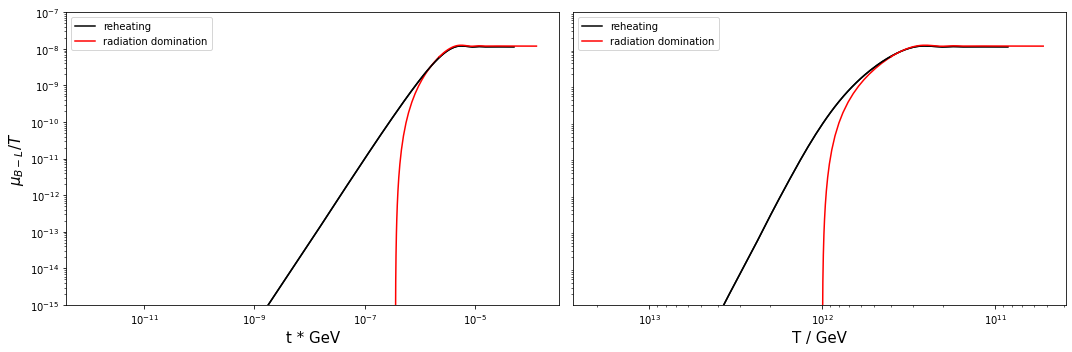

In [82]:
plot(ress_good, ress2_good, "rh_vs_raddom_good_case.pdf")

In [7]:
assert False

AssertionError: 

In [3]:
m_a_range = np.geomspace(1e6, 1e9, 21)
Gamma_phi_range = np.geomspace(1e6, 1e9, 20)
H_inf = 2e10
f_a = 3e14

In [9]:
%%time
eta_B_rh = [[model.solve(model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                                           axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), (m_a,), Gamma_phi, H_inf),
                              (1,0), f_a, calc_axion_mass=axion_motion.calc_const_axion_mass)
                 for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:9: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:12: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:9: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:12: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


CPU times: user 21min 24s, sys: 1.54 s, total: 21min 25s
Wall time: 21min 27s


In [10]:
%%time
eta_B_rad_dom = [[rad_dom_model.solve(rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                                                      rad_dom_axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), (m_a,)), 
                                 cosmology.calc_reheating_temperature(Gamma_phi), (1,0), f_a, calc_axion_mass=rad_dom_axion_motion.calc_const_axion_mass)
                for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

../transport_eq/axion_decay.py:9: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
../transport_eq/axion_decay.py:12: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


CPU times: user 17min 13s, sys: 1.29 s, total: 17min 15s
Wall time: 17min 17s


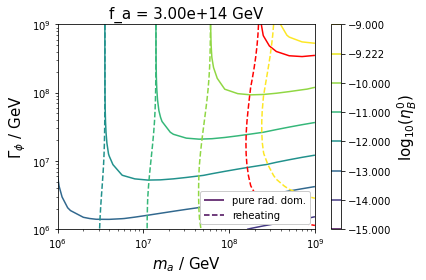

In [11]:
levels = np.hstack([np.arange(np.floor(np.log10(min(np.min(eta_B_rad_dom), np.min(eta_B_rh)))), 
          np.ceil(np.log10(max(np.max(eta_B_rad_dom), np.max(eta_B_rh)))),
          1), np.log10(constants.eta_B_observed)])
levels.sort()

CS = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rad_dom), levels)
plt.colorbar().set_label(r"$\log_{10} (\eta_B^0)$", fontsize=15)
CS.collections[np.where(CS.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

CS2 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rh), levels, linestyles="--")
CS2.collections[np.where(CS2.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

plt.title(f"f_a = {f_a:.2e} GeV", fontsize=15)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("$m_a$ / GeV", fontsize=15)
plt.ylabel(r"$\Gamma_\phi$ / GeV", fontsize=15)
h1, _ = CS.legend_elements()
h2, _ = CS2.legend_elements()
plt.legend([h1[0], h2[0]], ["pure rad. dom.", "reheating"], framealpha=1.0, loc=4)
plt.tight_layout()

In [12]:
t_start, init = reheating.calc_initial_reheating(H_inf)
#Gamma_phi = 1e8
t_end = 1e3*cosmology.switch_hubble_and_time_rad_dom(
    cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(cosmology.calc_reheating_temperature(Gamma_phi))))
T_fn, H_fn, T_dot_fn, _ = reheating.solve_reheating_eq(t_start, t_end, init, Gamma_phi)

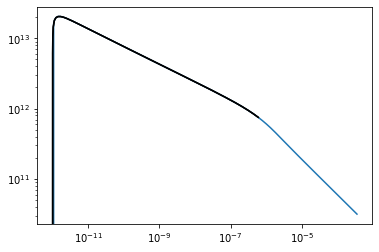

In [13]:
ts = np.geomspace(t_start, t_end, 300)
plt.loglog(ts, T_fn(ts))
for res in ress:
    plt.loglog(res.t, res.T_fn(res.t), "-k")

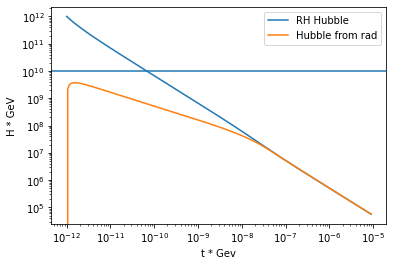

In [12]:
plt.loglog(ts, H_fn(ts), label="RH Hubble")
plt.loglog(ts, cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_fn(ts))), label="Hubble from rad")
plt.xlabel("t * Gev"); plt.ylabel("H * GeV"); plt.legend()
plt.axhline(m_a)

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in true_divide
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /


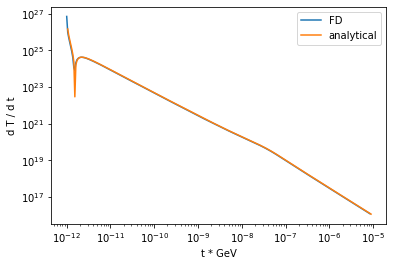

In [13]:
Ts = T_fn(ts)
T_dot_fd = (Ts[:-1] - Ts[1:]) / (ts[:-1] - ts[1:])
plt.plot(ts[:-1], np.abs(T_dot_fd), label="FD")
plt.plot(ts, np.abs(T_dot_fn(ts)), label="analytical")
plt.legend()
plt.xlabel("t * GeV")
plt.ylabel("d T / d t")
plt.xscale("log")
plt.yscale("log")

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in true_divide
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /


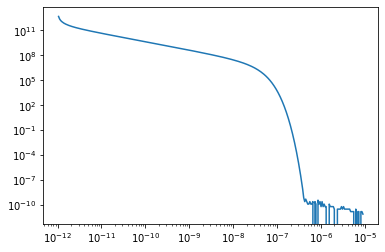

In [15]:
plt.loglog(ts, np.abs(T_dot_fn(ts) / T_fn(ts) + H_fn(ts)))

In [57]:
%%time

m_a = 1e10
def rhs(_t, y):
    theta, theta_dot = y
    theta_dot *= m_a
    t = _t / m_a
    T = T_fn(t)
    H = H_fn(t)
    a, b = axion_motion.axion_rhs_simple(t, T, H, (theta, theta_dot), 0.0, (m_a,))
    return a / t, b / t / m_a

#sol = solve_ivp(rhs, (np.log(t_start), np.log(t_end)), (1, 0), dense_output=True)
sol = solve_ivp(rhs, (t_start * m_a, t_end * m_a), (1, 0), dense_output=True) # , method="Radau", jac=axion_jac)

KeyboardInterrupt: 

In [54]:
plt.semilogx(ts, sol.sol(np.log(ts / m_a))[0])

IndexError: list index out of range

In [ ]:
def axion_jac(t, y):
    theta, theta_dot = y
    H = H_fn(t)
    T = T_fn(t)
    return np.array([
        [0,                                                     -1],
        [- axion_motion.calc_d2Vdtheta2_simple(T, theta, m_a), -3*H]
    ])